#### Лекция для кружка по машинному обучению ФПМИ

# Понижение размерности и методы визуализации данных
#### Самохин Валентин

#### План
1. Почему много признаков - это плохо?
2. Простейшие методы понижения размерности. Использование простых моделей для отбора признаков.
3. Дисперсия - зачем ее беречь?
4. PCA a.k.a. SVD
5. Kernel PCA
6. LLE
7. Как визуализация связана с понижением размерности? 
8. t-SNE

## 1. Почему много признаков - это плохо?

В реальных задачах специалистам доступны большие объемы данных, подробно описывающие исследуемые объекты и явления. Очевидно, что для того, чтобы по максимуму использовать их, модель нужно усложнять - вносить новые признаки, ограничения, добавлять регуляризацию для новых параметров. Все эти поправки плохо влияют на скорость обучения модели, а сложная структура пространства признаков может вообще препятствовать нахождению оптимальных параметров методами оптимизации.

Рассмотрим пример.


In [44]:
from IPython.display import Image
import warnings
warnings.simplefilter("ignore")

import matplotlib as mpl

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

(1797, 64)


<Figure size 432x288 with 0 Axes>

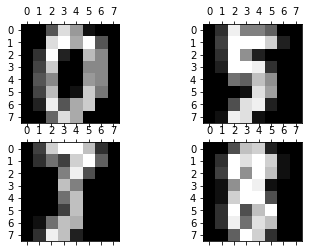

In [59]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
import numpy as np

digits = load_digits()
print(digits.data.shape)
import matplotlib.pyplot as plt
plt.gray() 
fig, ax = plt.subplots(2, 2)
for i in [0,1]:
    for j in [0,1]:
        ax[i, j].matshow(digits.images[103*i + 35*j])

In [12]:
X = digits.data
y = digits.target

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.3, 
                                                    random_state=42)

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

model = LogisticRegression()
%time model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy_score(y_test, y_pred)

CPU times: user 170 ms, sys: 20.3 ms, total: 190 ms
Wall time: 164 ms


0.9537037037037037

По примерам изображений видно, что края совершенно неинформативны, и мы можем от них избавиться

In [13]:
X_cutted = X.reshape((-1, 8, 8))[:, :, 1:7].reshape((-1, 8*6))
X_cutted.shape

(1797, 48)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_cutted, 
                                                    y, 
                                                    test_size=0.3, 
                                                    random_state=42)

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

model = LogisticRegression()
%time model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy_score(y_test, y_pred)

CPU times: user 117 ms, sys: 1.47 ms, total: 118 ms
Wall time: 118 ms


0.9537037037037037

Убрав ненужные пиксели, мы ожидаемо сохранили качество модели. Более того, в среднем мы получаем лучшее время обучения модели при сокращенном описании чисел. 

#### Проклятие размерности

Для метрических алгоритмов, основанных на расстоянии между объектами, размерность пространства признаков может оказывать серьезное влияние. Это связано с т.н. проклятием размерности.

Идеи, иллюстрирующие эту проблему:
1. Накопление незначительных отклонений.

Пусть объект представляется некоторым вектором $x = (x_1, x_2, \dots, x_n)$
С одной стороны, вектор $x_\epsilon = (x_1 + \epsilon, x_2 + \epsilon, \dots, x_n + \epsilon)$ получен из вектора $x$ незначительным изменением отдельных координат ($\epsilon$ мало). С другой стороны, вместе эти изменения приводят к значительным различиям между целыми объектами.

2. Экспоненциальный рост необходимых данных.

    * Для $N$ бинарных признаков общее число возможных вариантов равняется $2^N$. 
    * С другой стороны, мы можем рассмотреть n-мерный куб со стороной $l < 1$. Задачу уточнения положения точки с точностью до $l$ мы можем интерпретировать как вероятность попадания в малый куб. Тогда мы можем сказать, что "сложность" задачи растет экспоненциально как $l^n$

Таким образом, уменьшение размерности существенно влияет на эффективность алгоритмов, любым образом использующим расстояние. 

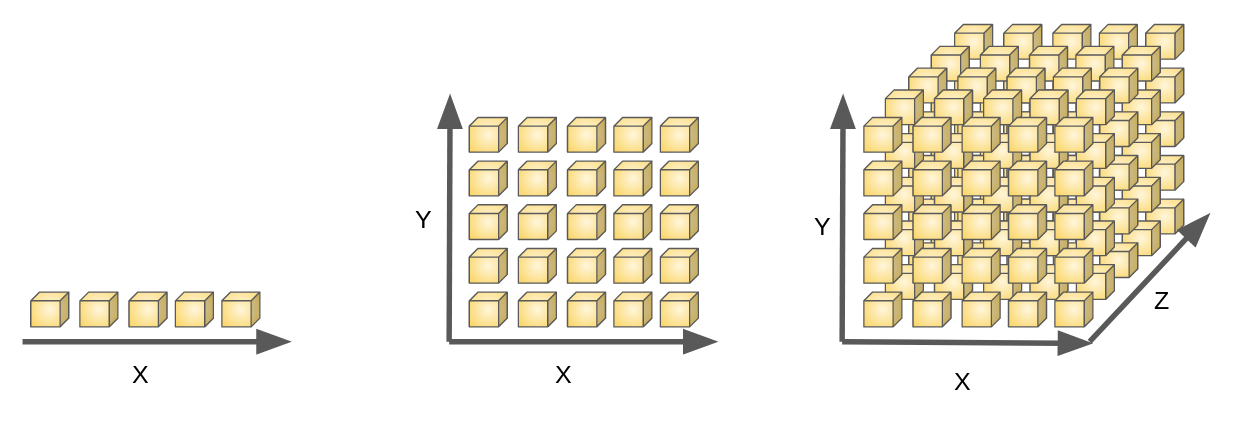

In [15]:
Image('boxes.png') #source: freecodecamp

#### Уточнение: 
Понижение размерности приводит к потери некоторой информации (аналогично сжатию картинок), поэтому, несмотря на возможное ускорение процесса обучения системы, мы можем столкнуться с небольшим ухудшением качества модели из-за такого сжатия.

#### Интерпретируемость модели

Поскольку машинное обучение глубоко проникло в нашу жизнь, возникла потребность как-то регулировать влияние т.н. AI. Так, в ЕС приняты законы, дающие право людям получать объяснение решений, принятых относительно них. Например, если модель, решающая задачу кредитного скоринга, отказала сомнительной персоне в выдаче средств, мы, как создатели модели и сотрудники банка, в который персона обратилась, должны объяснить причину, по которой произошло такое решение.

В случае, когда данные описываются большим набором признаков, сделать это очень проблематично. Понизив размерность задачи, можно более просто описать задачу, а в случае $n=2$ или $n=3$ измененные данные удастся даже провизуализировать.

## 2. Простейшие методы отбора признаков

Одним из методов, с помощью которого можно снижать, размерность задачи, является следующим. Чтобы приблизительно понять, какую информацию нам потерять не жалко, обучим простейшие модели (н-р, линейные) и посмотрим, какие признаки оказались наиболее важными. 

Начнем с линейных моделей и Lasso. Такой прием регуляризации позволяет занулять некоторые коэффициенты в линейной модели, что можно интерпретировать как отбор признаков. Отбирать признаки, можно и с помощью Ridge-регуляризации, но он подходит для этой цели несколько хуже.

In [16]:
from sklearn.svm import LinearSVC
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectFromModel
iris = load_iris()
X, y = iris.data, iris.target
print(X.shape)

lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(X, y)
model = SelectFromModel(lsvc, prefit=True)
X_new = model.transform(X)
print(X_new.shape)

(150, 4)
(150, 3)


 <img src='Lasso.png'></img>

Отбирать признаки можно и с помощью решающих деревьев.

In [17]:
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):  print(name, score)

sepal length (cm) 0.09393927792674572
sepal width (cm) 0.020969098461288357
petal length (cm) 0.46725372765541184
petal width (cm) 0.4178378959565539


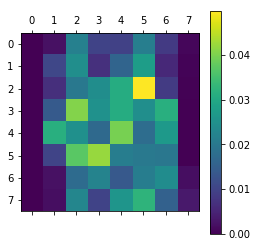

In [18]:
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(digits.data, digits.target)
plt.matshow(rnd_clf.feature_importances_.reshape(8, 8), cmap = 'viridis')
plt.colorbar()
plt.show()

### Univariate analysis

Для отбора признаков мы также можем использовать дисперсионный анализ. Для этого используется понятие ковариации - меры линейной зависимости между двумя величинами. Основной идеей такого статистического подхода является определение меры зависимости между целевым параметром и переменными. Простота такого метода объясняется тем, что этот подход рассматривает переменные исключительно по отдельности и потому не учитывает сложные зависимости между параметрами. Применив такой метод, можно быстро оценить влияние параметров на значение целевой переменной.

In [19]:
from sklearn.datasets import load_breast_cancer
from sklearn.feature_selection import SelectPercentile 
from sklearn.model_selection import train_test_split


cancer = load_breast_cancer()
# get deterministic random numbers
rng = np.random.RandomState(42)
noise = rng.normal(size=(len(cancer.data), 50))
# add noise features to the data
# the first 30 features are from the dataset, the next 50 are noise 
X_w_noise = np.hstack([cancer.data, noise])
X_train, X_test, y_train, y_test = train_test_split(X_w_noise, cancer.target, random_state=0, test_size=.5)
# use f_classif (the default) and SelectPercentile to select 50% of features
select = SelectPercentile(percentile=50)
select.fit(X_train, y_train)
# transform training set
X_train_selected = select.transform(X_train)
print("X_train.shape: {}".format(X_train.shape)) 
print("X_train_selected.shape: {}".format(X_train_selected.shape))

X_train.shape: (284, 80)
X_train_selected.shape: (284, 40)


Text(0.5, 0, 'Sample index')

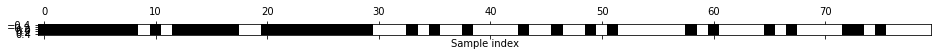

In [20]:
mask = select.get_support()
# visualize the mask -- black is True, white is False 
plt.matshow(mask.reshape(1, -1), cmap='gray_r') 
plt.xlabel("Sample index")

In [21]:
from sklearn.linear_model import LogisticRegression # transform test data
X_test_selected = select.transform(X_test)
lr = LogisticRegression()
lr.fit(X_train, y_train)
print("Score with all features: {:.3f}".format(lr.score(X_test, y_test))) 
lr.fit(X_train_selected, y_train)
print("Score with only selected features: {:.3f}".format(
lr.score(X_test_selected, y_test)))

Score with all features: 0.930
Score with only selected features: 0.940


#### Слегка усложненные подходы

Оба подхода, которые мы только что рассмотрели, похожи тем, что ограничиваются рассмотрением одной модели или одного признака. Существуют подходы, позволяющие комбинировать модели (iterative feature selection) и признаки (multivariate analysis).

## 3. LDA: обучение с учителем.

Начнем с метода, использующий знания о классах объектов. 
<img src='LDA.png'>

Выбираем новую систему координат так, чтобы классы было удобно разделять. Переход к новой системе координат осуществляется поворотом.

Кратко метод можем описать так:

1. Находим средние значения для каждого класса.
2. Смотрим коррелляцию внутри (within) каждого класса.

$$D_w = \sum_{i=1}^g (N_i - 1) D_i = \sum_{i=1}^g \sum_{j=1}^{N_i} (x_{i, j} - \overline{x_i}) (x_{i, j} - \overline{x_i})^T$$

3. Смотрим корреляцию между (berween) классами.
$$D_b = \sum_{i=1}^g N_i (\overline{x_i} - \overline{x})(\overline{x_i} - \overline{x})^T$$
4. Находим проекцию в пространство меньшей размерности такую, чтобы межклассовая дисперсия была максимальной, а внутриклассовая дисперсия была минимальной.
$$P = \arg \max_P \dfrac{P^TS_bP}{P^TS_wP}$$

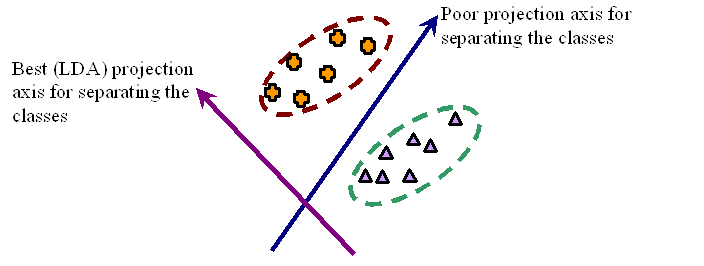

In [22]:
Image('good_bad_lda.png')

explained variance ratio (first two components): [0.92461872 0.05306648]


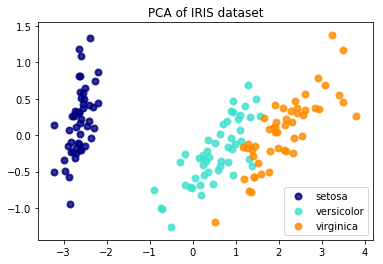

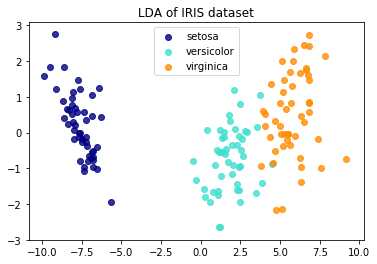

In [23]:

import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

iris = datasets.load_iris()

X = iris.data
y = iris.target
target_names = iris.target_names

pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)

lda = LinearDiscriminantAnalysis(n_components=2)
X_r2 = lda.fit(X, y).transform(X)

# Percentage of variance explained for each components
print('explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))

plt.figure()
colors = ['navy', 'turquoise', 'darkorange']
lw = 2

for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=.8, lw=lw,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA of IRIS dataset')

plt.figure()
for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    plt.scatter(X_r2[y == i, 0], X_r2[y == i, 1], alpha=.8, color=color,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('LDA of IRIS dataset')

plt.show()

## 4. PCA: взрослая жизнь без учителей.

PCA, по сути, аналогичен описанному выше $LDA$, за исключением целевых меток - в задачи обучения без учителя они отсутствуют. Мы просто стремимся сохранить дисперсию между элементами максимальной.


Идея метода состоит в том, чтобы сохранить как можно больше информации о выборке. Предлагается это делать следующим образом:
1. На первом шаге мы находим направление, сумма квадратов длин проекций исходных векторов на которое максимальна
2. Затем, мы из исходных векторов вычитаем проекции на найденное направление.
3. На полученных данных ищем следующую компоненту

Математически задача выглядит следующим образом:

$${\mathbf  {w}}={\underset  {\Vert {\mathbf  {w}}\Vert =1}{\operatorname {\arg \,max}}}\,\left\{\sum _{i}\left({\mathbf  {x}}_{{(i)}}\cdot {\mathbf  {w}}\right)^{2}\right\}$$

Оказывается, что эта задача имеет очень простое решение: первые $d$ направлений - это есть собственные вектора матрицы $X^TX$. Их можно просто найти с помощью SVD разложения матрицы $X$ 

In [24]:
from six.moves import urllib
try:
    from sklearn.datasets import fetch_openml
    mnist = fetch_openml('mnist_784', version=1)
    mnist.target = mnist.target.astype(np.int64)
except ImportError:
    from sklearn.datasets import fetch_mldata
    mnist = fetch_mldata('MNIST original')

In [25]:
from sklearn.model_selection import train_test_split

X = mnist["data"]
y = mnist["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [26]:
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

In [27]:
d

154

In [28]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)

In [29]:
pca.n_components_

154

In [30]:
pca = PCA(n_components = 154)
X_reduced = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced)

In [31]:
def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

Text(0.5, 1.0, 'Compressed')

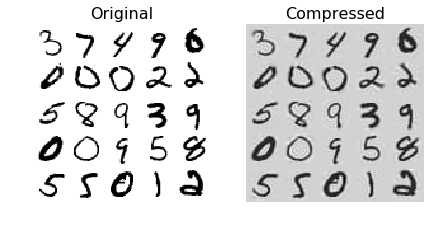

In [32]:
plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.title("Original", fontsize=16)
plt.subplot(122)
plot_digits(X_recovered[::2100])
plt.title("Compressed", fontsize=16)


## 5. Kernel PCA

Kernel trick - математический прием, использующийся для неявного отображения признаков в пространство более высокой размерности. 
Наиболее известным примером является SVM. Там, при использовании Kernel trick, мы получаем возможность строить линейную разделяющую поверхность в пространстве высокой размерности, которая в исходном пространстве линейной уже не будет.


In [33]:
from sklearn.datasets import make_swiss_roll
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

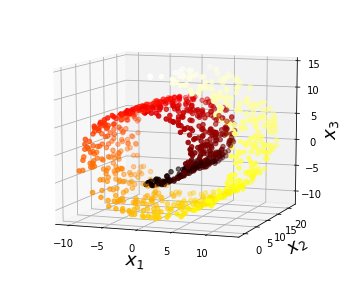

In [50]:
axes = [-11.5, 14, -2, 23, -12, 15]

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=t, cmap=plt.cm.hot)
ax.view_init(10, -70)
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

plt.show()

In [51]:
from sklearn.decomposition import KernelPCA

rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.04)
X_reduced = rbf_pca.fit_transform(X)

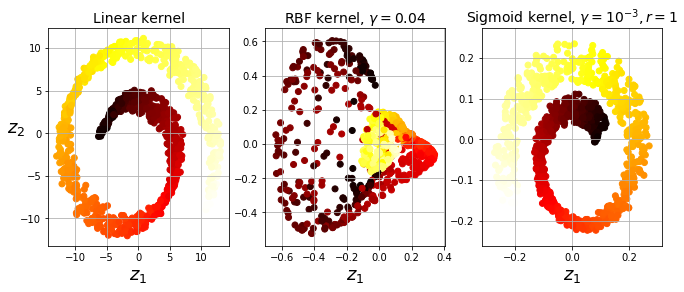

In [53]:
from sklearn.decomposition import KernelPCA

lin_pca = KernelPCA(n_components = 2, kernel="linear", fit_inverse_transform=True)
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True)
sig_pca = KernelPCA(n_components = 2, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True)

y = t > 6.9

plt.figure(figsize=(11, 4))
for subplot, pca, title in ((131, lin_pca, "Linear kernel"), (132, rbf_pca, "RBF kernel, $\gamma=0.04$"), (133, sig_pca, "Sigmoid kernel, $\gamma=10^{-3}, r=1$")):
    X_reduced = pca.fit_transform(X)
    if subplot == 132:
        X_reduced_rbf = X_reduced
    
    plt.subplot(subplot)
    #plt.plot(X_reduced[y, 0], X_reduced[y, 1], "gs")
    #plt.plot(X_reduced[~y, 0], X_reduced[~y, 1], "y^")
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

plt.show()

Подбор гиперпараметров:
* Поиск по сетке - как часть pipeline (при использовании в задачах с учителем)
* Отдельно - минимизируя ошибку при восстановлении.

## 6. LLE - Locally Linear Embedding

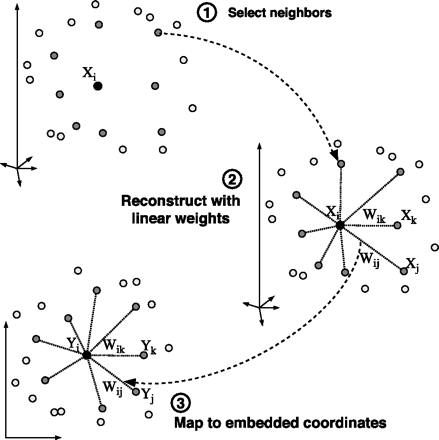

In [54]:
Image('lle_scheme.gif') #cs.nyu.edu

Метод был придуман из интуитивного предположения о т.н. manifold learning, что если мы имеем хорошую выборку данных из некоторого распределения, то любая точка вместе с соседям локально лежит на некоторой плоскости. Так, сначала мы определяем для каждой точки расстояния до соседей, а затем ищем представление более низкой размерности так, чтобы найденные расстояния лучшим образом сохранялись.

1. Для каждого элемента из выборка определяем $k$ ближайших соседей.
2. Восстановливаем выбранный элемент как линейную функцию от своих соседей (ищем лучшее приближение в смысле квадратичной ошибки). Перебрав все элементы, получим матрицу $W$

$$\hat{W} = \arg\min_W \sum_{i=1}^{m}\left(x^{(i)} - \sum_{j=1}^m w_{i, j}x^{(j)}\right)^2$$

$$s.t. 
\begin{cases}
    w_{i,j} = 0,\ \text{если}\ x^{(j)}\ \text{не является соседом}\ x^{(i)} \\
    \sum_{j=1}^{m}w_{i, j} = 1,\ i = \overline{1, m}
\end{cases}
$$
3. Коэффициенты в линейной комбинации задают локально линейную связь между элементами выборки.
4. Отображение в пространство меньшей размерности:

$$\hat{Z} = \arg\min_W \sum_{i=1}^{m}\left(x^{(i)} - \sum_{j=1}^m w_{i, j}x^{(j)}\right)^2$$

In [55]:
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=41)

In [56]:
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_reduced = lle.fit_transform(X)

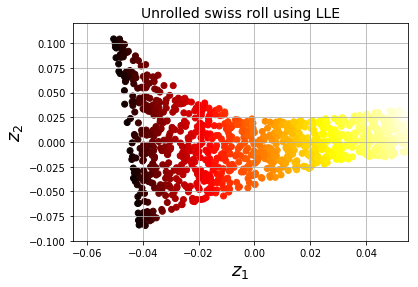

In [57]:
plt.title("Unrolled swiss roll using LLE", fontsize=14)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18)
plt.axis([-0.065, 0.055, -0.1, 0.12])
plt.grid(True)

plt.show()

Сложность метода существенно зависит от размера выборки, поэтому он плохо масштабируется на большие датасеты.

## 7. Визуализация

Задача визуализации - частный случай понижения размерности, когда искомое пространство, в которое мы отображаем выборку, имеет размерность 2 или 3. При этом отображении важно сохранить структуру и закономерности.

##### Почему это важно?

Вообще говоря, всегда полезно иметь представление о данных. Более естественно рассматривать выборку на плоскости или в 3-хмерном пространстве. Зная, как выглядит датасет, можно выдвигать более эффективные гипотезы о зависимости данных.
В то же время, рассматривая признаки попарно или тройками, не всегда можно получить цельное преставление. 


### t-SNE

Stochastic Neighbor Embedding (SNE) - вероятностный метод снижения размерности. Достаточно популярный метод в приложениях.

Суть базового метода заключается в следующем:
 - Определяется "похожесть" двух объектов $x_j$  и $x_i$ как условная вероятность $p_{j\vert i}$. Делается предположение, что вероятность того, что ты окажешься соседом $x_i$ пропорциональна плотности нормального распределения с центром в $x_i$.

$$p_{j\vert i} = \frac{\exp\big(\frac{ - \vert x_i - x_j \vert^2}{\sigma_i^2}\big)}{\sum_{k \neq i} \exp\big(\frac{ - \vert x_i - x_k \vert^2}{\sigma_i^2}\big)}$$

 - Мы хотим найти низкоразмерное представление $y_i$ вектора $x_i$. Теперь мы говорим, что в низкоразмерность тоже есть эта похожесть $q_{j\vert i}$, которую мы можем записать как

$$q_{j\vert i} = \frac{\exp\big(- \vert y_i - y_j \vert^2\big)}{\sum_{k \neq i} \exp\big(- \vert y_i - y_k \vert^2\big)}$$

 - А теперь мы хотим, чтобы эти распределения были как можно ближе друг к другу. Как померить расстояния между распределениями? Есть такое расстояние (дивергенция) Кульбака - Лейблера, которое считается следующим образом:
 $${\displaystyle D_{\mathrm {KL} }(P\|Q)=\int _{X}\,p(x)\log {\frac {p(x)}{q(x)}}\,{\rm {d}}x}$$
Нужно отметить, что расстоянием эта функция называется весьма условно - эта функция не симметрична. Более строго будет считать, что дивергенция Кульбака-Лейбнера считает меру вложенности двух распределений.

В нашем случае будет считаться его дискретный вариант

$${\displaystyle \sum_{i} D_{KL}(P_i||Q_i)=\sum \limits _{i} \sum \limits _{j}p_{j\vert i}\log {\frac {p_{j\vert i}}{q_{j\vert i}}}}.$$

Таким образом, задача, решаемая SNE - __минимизация дивергенции Кульбака-Лейбнера__.

А дальше идут навороты:
 - На самом деле мы можем оптимизировать не для условных вероятностей, а для совместных, причём пологать, что $p_{ji} = p_{ij}$ и $q_{ji} = q_{ij}$. $q_{ij}$ оставляют как условное, а $p_{ij} = \frac{p_{j\vert i} + p_{i\vert j}}{2n}$. Вот это симметричный вариант.
 
 - А теперь говорят, что в низкоразмерном брать нормальное распределение не очень, давайте возьмём распределение Стьюдента, которое используется в t-SNE.
 $${\displaystyle q_{ij}={\frac {(1+\lVert \mathbf {y} _{i}-\mathbf {y} _{j}\rVert ^{2})^{-1}}{\sum _{k\neq i}(1+\lVert \mathbf {y} _{i}-\mathbf {y} _{k}\rVert ^{2})^{-1}}}}$$

У метода SNE есть проблема: объекты в многомерном пространстве легче разместить рядом, чем в маломерном, а используемая евклидова метрика слишком сильно штрафует за несохранение пропорций.  Метод t-SNE старается решить эту проблему, используя другой способ вычисления распределений в новом пространстве.

Рассмотрим примет из документации _sklearn_. Одним из важных параметров метода t-SNE является _perplexity_. Неформально можно сказать, что он определяет, насколько важно учитывать дальних соседей. Этот параметр существенно влияет на картинку.

circles, perplexity=5 in 0.87 sec
circles, perplexity=30 in 0.87 sec
circles, perplexity=50 in 1.4 sec
circles, perplexity=100 in 1.5 sec
S-curve, perplexity=5 in 0.93 sec
S-curve, perplexity=30 in 1.2 sec
S-curve, perplexity=50 in 1.2 sec
S-curve, perplexity=100 in 1.7 sec
uniform grid, perplexity=5 in 0.86 sec
uniform grid, perplexity=30 in 1 sec
uniform grid, perplexity=50 in 1 sec
uniform grid, perplexity=100 in 1.7 sec


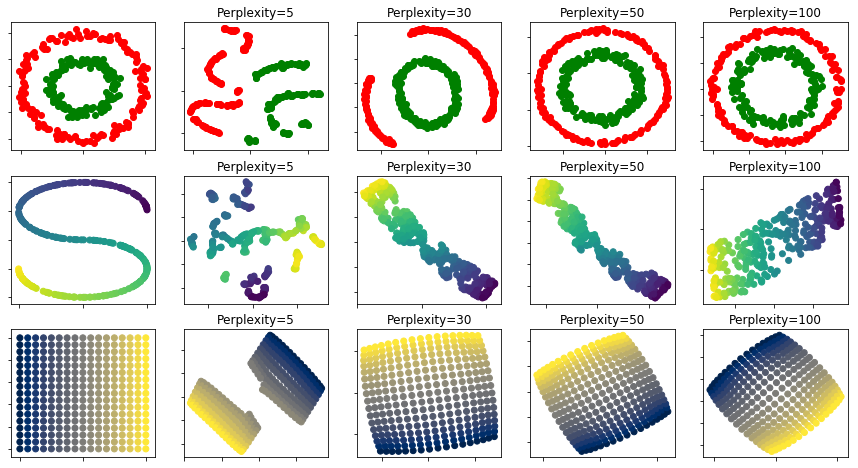

In [66]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.ticker import NullFormatter
from sklearn import manifold, datasets
from time import time

n_samples = 300
n_components = 2
(fig, subplots) = plt.subplots(3, 5, figsize=(15, 8))
perplexities = [5, 30, 50, 100]

X, y = datasets.make_circles(n_samples=n_samples, factor=.5, noise=.05)

red = y == 0
green = y == 1

ax = subplots[0][0]
ax.scatter(X[red, 0], X[red, 1], c="r")
ax.scatter(X[green, 0], X[green, 1], c="g")
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')

for i, perplexity in enumerate(perplexities):
    ax = subplots[0][i + 1]

    t0 = time()
    tsne = manifold.TSNE(n_components=n_components, init='random',
                         random_state=0, perplexity=perplexity)
    Y = tsne.fit_transform(X)
    t1 = time()
    print("circles, perplexity=%d in %.2g sec" % (perplexity, t1 - t0))
    ax.set_title("Perplexity=%d" % perplexity)
    ax.scatter(Y[red, 0], Y[red, 1], c="r")
    ax.scatter(Y[green, 0], Y[green, 1], c="g")
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis('tight')

# Another example using s-curve
X, color = datasets.samples_generator.make_s_curve(n_samples, random_state=0)

ax = subplots[1][0]
ax.scatter(X[:, 0], X[:, 2], c=color, cmap = 'viridis')
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())

for i, perplexity in enumerate(perplexities):
    ax = subplots[1][i + 1]

    t0 = time()
    tsne = manifold.TSNE(n_components=n_components, init='random',
                         random_state=0, perplexity=perplexity)
    Y = tsne.fit_transform(X)
    t1 = time()
    print("S-curve, perplexity=%d in %.2g sec" % (perplexity, t1 - t0))

    ax.set_title("Perplexity=%d" % perplexity)
    ax.scatter(Y[:, 0], Y[:, 1], c=color, cmap='viridis')
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis('tight')


# Another example using a 2D uniform grid
x = np.linspace(0, 1, int(np.sqrt(n_samples)))
xx, yy = np.meshgrid(x, x)
X = np.hstack([
    xx.ravel().reshape(-1, 1),
    yy.ravel().reshape(-1, 1),
])
color = xx.ravel()
ax = subplots[2][0]
ax.scatter(X[:, 0], X[:, 1], c=color, cmap = 'cividis')
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())

for i, perplexity in enumerate(perplexities):
    ax = subplots[2][i + 1]

    t0 = time()
    tsne = manifold.TSNE(n_components=n_components, init='random',
                         random_state=0, perplexity=perplexity)
    Y = tsne.fit_transform(X)
    t1 = time()
    print("uniform grid, perplexity=%d in %.2g sec" % (perplexity, t1 - t0))

    ax.set_title("Perplexity=%d" % perplexity)
    ax.scatter(Y[:, 0], Y[:, 1], c=color, cmap='cividis')
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis('tight')


plt.show()

## 9. Что мы пропустили?

Computing random projection
Computing Linear Discriminant Analysis projection
Computing Isomap embedding
Done.
Computing MDS embedding
Done. Stress: 139038449.030948
Computing Spectral embedding
Computing t-SNE embedding


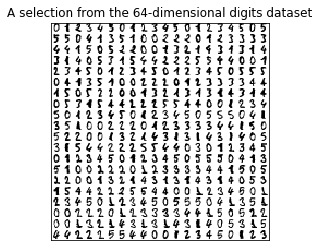

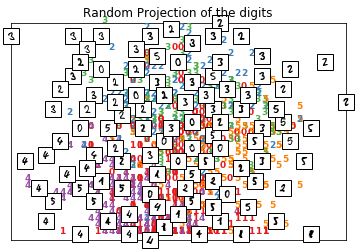

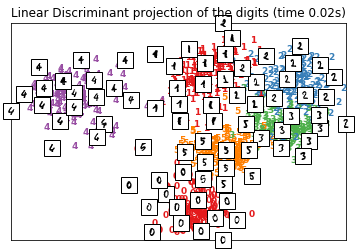

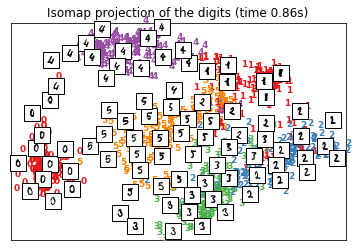

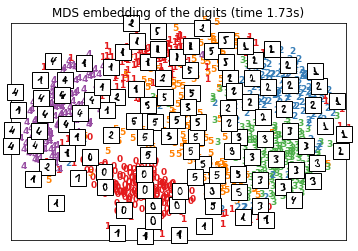

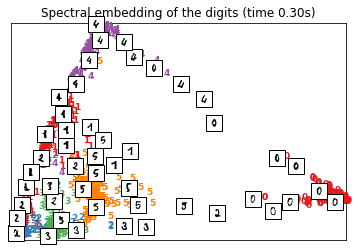

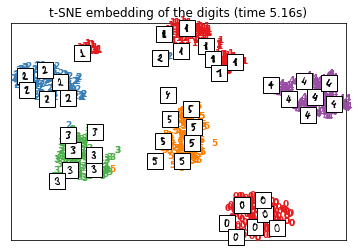

In [70]:
from time import time

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import offsetbox
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection)

digits = datasets.load_digits(n_class=6)
X = digits.data
y = digits.target
n_samples, n_features = X.shape
n_neighbors = 30


#----------------------------------------------------------------------
# Scale and visualize the embedding vectors
def plot_embedding(X, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure()
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(y[i]),
                 color=plt.cm.Set1(y[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})

    if hasattr(offsetbox, 'AnnotationBbox'):
        # only print thumbnails with matplotlib > 1.0
        shown_images = np.array([[1., 1.]])  # just something big
        for i in range(X.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < 4e-3:
                # don't show points that are too close
                continue
            shown_images = np.r_[shown_images, [X[i]]]
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(digits.images[i], cmap=plt.cm.gray_r),
                X[i])
            ax.add_artist(imagebox)
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)


#----------------------------------------------------------------------
# Plot images of the digits
n_img_per_row = 20
img = np.zeros((10 * n_img_per_row, 10 * n_img_per_row))
for i in range(n_img_per_row):
    ix = 10 * i + 1
    for j in range(n_img_per_row):
        iy = 10 * j + 1
        img[ix:ix + 8, iy:iy + 8] = X[i * n_img_per_row + j].reshape((8, 8))

plt.imshow(img, cmap=plt.cm.binary)
plt.xticks([])
plt.yticks([])
plt.title('A selection from the 64-dimensional digits dataset')


#----------------------------------------------------------------------
# Random 2D projection using a random unitary matrix
print("Computing random projection")
rp = random_projection.SparseRandomProjection(n_components=2, random_state=42)
X_projected = rp.fit_transform(X)
plot_embedding(X_projected, "Random Projection of the digits")


#----------------------------------------------------------------------
# Projection on to the first 2 linear discriminant components

print("Computing Linear Discriminant Analysis projection")
X2 = X.copy()
X2.flat[::X.shape[1] + 1] += 0.01  # Make X invertible
t0 = time()
X_lda = discriminant_analysis.LinearDiscriminantAnalysis(n_components=2).fit_transform(X2, y)
plot_embedding(X_lda,
               "Linear Discriminant projection of the digits (time %.2fs)" %
               (time() - t0))


#----------------------------------------------------------------------
# Isomap projection of the digits dataset
print("Computing Isomap embedding")
t0 = time()
X_iso = manifold.Isomap(n_neighbors, n_components=2).fit_transform(X)
print("Done.")
plot_embedding(X_iso,
               "Isomap projection of the digits (time %.2fs)" %
               (time() - t0))


#----------------------------------------------------------------------
# MDS  embedding of the digits dataset
print("Computing MDS embedding")
clf = manifold.MDS(n_components=2, n_init=1, max_iter=100)
t0 = time()
X_mds = clf.fit_transform(X)
print("Done. Stress: %f" % clf.stress_)
plot_embedding(X_mds,
               "MDS embedding of the digits (time %.2fs)" %
               (time() - t0))


#----------------------------------------------------------------------
# Spectral embedding of the digits dataset
print("Computing Spectral embedding")
embedder = manifold.SpectralEmbedding(n_components=2, random_state=0,
                                      eigen_solver="arpack")
t0 = time()
X_se = embedder.fit_transform(X)

plot_embedding(X_se,
               "Spectral embedding of the digits (time %.2fs)" %
               (time() - t0))

#----------------------------------------------------------------------
# t-SNE embedding of the digits dataset
print("Computing t-SNE embedding")
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
t0 = time()
X_tsne = tsne.fit_transform(X)

plot_embedding(X_tsne,
               "t-SNE embedding of the digits (time %.2fs)" %
               (time() - t0))

plt.show()

standard: 0.12 sec
ltsa: 0.19 sec
hessian: 0.28 sec
modified: 0.21 sec
Isomap: 0.36 sec
MDS: 1.5 sec
SpectralEmbedding: 0.06 sec
t-SNE: 6.6 sec


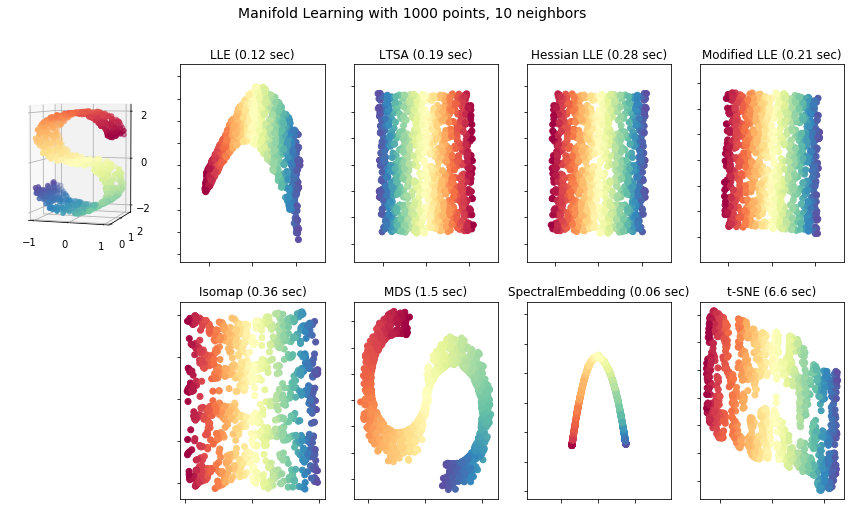

In [71]:
from time import time

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter

from sklearn import manifold, datasets

# Next line to silence pyflakes. This import is needed.
Axes3D

n_points = 1000
X, color = datasets.samples_generator.make_s_curve(n_points, random_state=0)
n_neighbors = 10
n_components = 2

fig = plt.figure(figsize=(15, 8))
plt.suptitle("Manifold Learning with %i points, %i neighbors"
             % (1000, n_neighbors), fontsize=14)


ax = fig.add_subplot(251, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, cmap=plt.cm.Spectral)
ax.view_init(4, -72)

methods = ['standard', 'ltsa', 'hessian', 'modified']
labels = ['LLE', 'LTSA', 'Hessian LLE', 'Modified LLE']

for i, method in enumerate(methods):
    t0 = time()
    Y = manifold.LocallyLinearEmbedding(n_neighbors, n_components,
                                        eigen_solver='auto',
                                        method=method).fit_transform(X)
    t1 = time()
    print("%s: %.2g sec" % (methods[i], t1 - t0))

    ax = fig.add_subplot(252 + i)
    plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
    plt.title("%s (%.2g sec)" % (labels[i], t1 - t0))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')

t0 = time()
Y = manifold.Isomap(n_neighbors, n_components).fit_transform(X)
t1 = time()
print("Isomap: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(257)
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
plt.title("Isomap (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')


t0 = time()
mds = manifold.MDS(n_components, max_iter=100, n_init=1)
Y = mds.fit_transform(X)
t1 = time()
print("MDS: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(258)
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
plt.title("MDS (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')


t0 = time()
se = manifold.SpectralEmbedding(n_components=n_components,
                                n_neighbors=n_neighbors)
Y = se.fit_transform(X)
t1 = time()
print("SpectralEmbedding: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(259)
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
plt.title("SpectralEmbedding (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')

t0 = time()
tsne = manifold.TSNE(n_components=n_components, init='pca', random_state=0)
Y = tsne.fit_transform(X)
t1 = time()
print("t-SNE: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(2, 5, 10)
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
plt.title("t-SNE (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')

plt.show()

## Вопросы?
